In [1147]:
import pandas as pd
import numpy as np
from numpy.linalg import eig
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from kmeans import K_Means
from svd import SVD

In [1148]:
data = pd.read_excel('data/Course Recommendation System(1-162).xlsx')
data = data.drop(data.iloc[:, 0:6], axis=1) # Delete unnecessary columns
data_core = data.iloc[:, :5]

courses = list(data.columns)
core_courses = list(data_core.columns)
elective_courses = list(data.iloc[:, 5:].columns)

In [1149]:
X_orig = data.to_numpy()
X = data.fillna(0.5).to_numpy()

from sklearn.model_selection import train_test_split
X, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [1150]:
Svd = SVD(X[:, :5])
u, s, vh = Svd.return_trunc_matrices(X[:, :5], 1)
print(Svd.singularvalues / Svd.singularvalues.sum() * 100)
X_SVD = np.dot(u @ s, vh).T

X_core = X_SVD[:, :5]
X_electives = X_SVD[:, 5:]

[57.74880533 13.43357967 11.17623231 10.03351379  7.6078689 ]


In [1151]:
X_SVD[0]

array([ 0.92266256,  0.02220077,  0.99853078, -0.01548958,  1.06753028])

X_core contains our user vectors (ratings for each user in the core courses)

In [1152]:
# K-means on user vectors

# Inertia = []

# for i in range(2, 10):
# 	kmeans = K_Means(i, 10)
# 	kmeans.fit(X_core, 75)
# 	Inertia.append(kmeans.inertia)

# plt.plot(range(2, 10), Inertia, 'o-')
# plt.xticks(range(2, 10))
# plt.title('The Elbow Method after SVD')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia / Distortion')
# plt.show()

In [1153]:
import numpy as np
from sklearn.decomposition import PCA

def Pca(n):
	pca = PCA(n_components=n).fit(X_core)

	print(pca.explained_variance_ratio_.cumsum())
	kmeans_reduced = pca.transform(X_core)
	kmeans_reduced.shape
	
	Inertia = []

	for i in range(2, 10):
		kmeans = K_Means(i, 10)
		kmeans.fit(kmeans_reduced, 75)
		Inertia.append(kmeans.inertia)

	plt.plot(range(2, 10), Inertia, 'o-')
	plt.xticks(range(2, 10))
	plt.title(f'The Elbow Method (After PCA reduction to {n} dim)')
	plt.xlabel('Number of clusters')
	plt.ylabel('Inertia / Distortion')
	plt.show()

# Pca(2)

In [1154]:
# Pca(1)

In [1155]:
n_clusters = 5
n_init = 10
kmeans = K_Means(n_clusters, n_init)
kmeans.fit(X_core, 100)
kmeans.get_cluster_size()
cluster_assignment = kmeans.c_assignment

In [1156]:
Svd = SVD(X)
u, s, vh = Svd.return_trunc_matrices(X, 1)
print(Svd.singularvalues / Svd.singularvalues.sum() * 100)
X_SVD = np.dot(u @ s, vh).T

[32.33321484  6.57938703  5.72337563  4.47422089  3.97622187  3.92795763
  3.81449589  3.65787706  3.57702882  3.14607103  3.08641323  2.96856058
  2.62062171  2.46174559  2.40757069  2.24070779  2.19681284  1.98018076
  1.71800254  1.63800915  1.43733092  1.3109459   1.01693142  0.95852036
  0.74779583]


In [1157]:
X_comp = np.zeros((1, 25))

for i in range(n_clusters):
    mean = np.mean(X_SVD[np.where(cluster_assignment == i)], axis=0).reshape(1, -1)
    X_comp = np.vstack((X_comp, mean))
    
X_comp = X_comp[1:, :]
X_comp.shape

(5, 25)

In [1158]:
# numpy 
u, s, vh = np.linalg.svd(X_comp, full_matrices=False)
print(u.shape, s.shape, vh.shape)
np.allclose(X_comp, np.dot(u * s, vh))

Svd = SVD(X_comp)
u, s, vh = Svd.return_trunc_matrices(X_comp, 2)
print(u.shape, s.shape, vh.shape)
print(Svd.singularvalues / Svd.singularvalues.sum() * 100)

X_svd = np.dot(u @ s, vh)

(5, 5) (5,) (5, 25)
(5, 3) (3, 3) (3, 25)
[70.76250606 12.30581148  7.28907378  6.48732841  3.15528027]


In [1159]:
def get_predictions(n, X):
	recs = {}
	for i in range(X.shape[0]):
		ind = np.argpartition(X[i, :], -n)[-n:]
		ind = ind[np.argsort(X_svd[i, :][ind])]
		print("Cluster - ", i + 1, "\n")
		print(X_svd[i, :][ind][::-1])
		print([elective_courses[i] for i in ind[::-1]], "\n")
		recs[i] = [elective_courses[i] for i in ind[::-1]]
		# recs[i] = ind

	return recs

recommendations = get_predictions(5, X_svd[:, 5:])

Cluster -  1 

[0.70158377 0.6776888  0.55777937 0.39482124 0.39178869]
['Software Production Engineering\n', 'Machine Learning\n', 'Data Visualization\n', 'Techno-economics of networks ', 'The Web and the Mind '] 

Cluster -  2 

[0.71788537 0.68132063 0.52347331 0.3364262  0.15452981]
['Software Production Engineering\n', 'Machine Learning\n', 'Cloud Computing\n', 'The Web and the Mind ', 'Visual Recognition\n'] 

Cluster -  3 

[0.92817971 0.86677464 0.86376579 0.73679233 0.08792915]
['Visual Recognition\n', 'Machine Learning\n', 'Reinforcement Learning', 'Mathematics For Machine Learning\n', 'Natural Language Processing\n'] 

Cluster -  4 

[0.84921036 0.80766306 0.79771824 0.75861022 0.62326578]
['Mathematics For Machine Learning\n', 'Reinforcement Learning', 'Machine Learning\n', 'Visual Recognition\n', 'Data Visualization\n'] 

Cluster -  5 

[0.80366727 0.77134428 0.54380878 0.37766608 0.30266908]
['Software Production Engineering\n', 'Machine Learning\n', 'Programming Language

In [1160]:
recommendations

{0: ['Software Production Engineering\n',
  'Machine Learning\n',
  'Data Visualization\n',
  'Techno-economics of networks ',
  'The Web and the Mind '],
 1: ['Software Production Engineering\n',
  'Machine Learning\n',
  'Cloud Computing\n',
  'The Web and the Mind ',
  'Visual Recognition\n'],
 2: ['Visual Recognition\n',
  'Machine Learning\n',
  'Reinforcement Learning',
  'Mathematics For Machine Learning\n',
  'Natural Language Processing\n'],
 3: ['Mathematics For Machine Learning\n',
  'Reinforcement Learning',
  'Machine Learning\n',
  'Visual Recognition\n',
  'Data Visualization\n'],
 4: ['Software Production Engineering\n',
  'Machine Learning\n',
  'Programming Languages\n',
  'Mathematics For Machine Learning\n',
  'Visual Recognition\n']}

In [1161]:
def get_mse(x, x_pred):

	mse = 0
	for p in x:
		c = kmeans.find_cluster(kmeans.clusters, p[:5])
		predictions = x_pred[c]

		temp = 0
		count = 0
		for i in range(p.shape[0]):
			if not np.isnan(p[i]): 
				count += 1
				temp += ((p[i] - predictions[i])**2)
				
		mse += (temp / count)
	return mse / x.shape[0]
		
# get_mse(X_orig, X_svd)

In [1166]:
mse = []

for i in range(n_clusters):
	Svd = SVD(X_comp)
	u, s, vh = Svd.return_trunc_matrices(X_comp, i)

	X_svd = np.dot(u @ s, vh)
	mse.append(get_mse(X_orig, X_svd))
print(mse)

[0.09082576039441805, 0.09175247411408359, 0.09474361367135259, 0.10046747683495111, 0.11006791377000835]


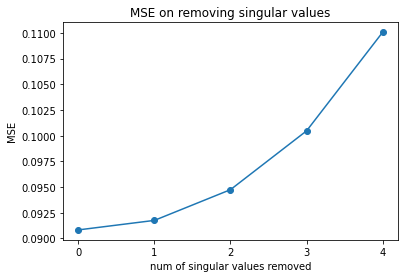

In [1170]:
plt.plot(range(5), mse, 'o-')
plt.xticks(range(5))
plt.title(f'MSE on removing singular values')
plt.xlabel('num of singular values removed')
plt.ylabel('MSE')
plt.show()

In [1163]:
def get_recommendations(p):
    c = kmeans.find_cluster(kmeans.clusters, p)
    return recommendations[c]

In [1110]:
def get_accuracy(n, X, X_pred):
	temp = []
	acc = 0
	for i in range(X.shape[0]):

		pred = get_recommendations(X_core[i])
		
		ind = np.argpartition(X[i, :], -n)[-n:]
		ind = ind[np.argsort(X[i, :][ind])]
		true = [elective_courses[i] for i in ind[::-1]]

		# print(pred, true)
		for i in pred:
			for j in true:
				if i == j:
					acc += 1
	print(acc)
	return  (acc / (5 * X.shape[0])) * 100

# get_accuracy(5, X_SVD[:, 5:], X_svd[:, 5:])

In [1111]:
def K_vs_Accuracy(k):

	Svd = SVD(X[:, :5])
	u, s, vh = Svd.return_trunc_matrices(X, 1)
	X_SVD = np.dot(u @ s, vh).T
	X_core = X_SVD[:, :5]
	X_electives = X_SVD[:, 5:]
	
	n_clusters = k
	n_init = 10
	kmeans = K_Means(n_clusters, n_init)
	kmeans.fit(X_core, 100)
	kmeans.get_cluster_size()
	cluster_assignment = kmeans.c_assignment

	# Svd = SVD(X)
	# u, s, vh = Svd.return_trunc_matrices(X, 1)
	# X_SVD = np.dot(u @ s, vh).T

	X_comp = np.zeros((1, 25))
	for i in range(n_clusters):
		mean = np.mean(X_SVD[np.where(cluster_assignment == i)], axis=0).reshape(1, -1)
		X_comp = np.vstack((X_comp, mean))

	X_comp = X_comp[1:, :]

	num_elect = 5
	acc_percent = []
	for i in range(k):
		Svd = SVD(X_comp)
		u, s, vh = Svd.return_trunc_matrices(X_comp, i)
		print(Svd.singularvalues)
		X_svd = np.dot(u @ s, vh)
		
		recs = {}
		for i in range(X_svd[:, 5:].shape[0]):
			ind = np.argpartition(X_svd[:, 5:][i, :], -num_elect)[-num_elect:]
			ind = ind[np.argsort(X_svd[i, :][ind])]
			recs[i] = [elective_courses[i] for i in ind[::-1]]
		print(recs)

		acc = 0
		for i in range(X_SVD.shape[0]):

			pred = recs[kmeans.find_cluster(kmeans.clusters, X_SVD[i, :5])]

			ind = np.argpartition(X_SVD[i, 5:], -num_elect)[-num_elect:]
			ind = ind[np.argsort(X_SVD[i, 5:][ind])]
			true = [elective_courses[i] for i in ind[::-1]]

			for i in pred:
				for j in true:
					if i == j:
						acc += 1
			# print(acc)
		acc_percent.append((acc / (num_elect * X_SVD.shape[0])) * 100)
	return  acc_percent

In [1112]:
# result = []

# for i in range(2, 9):
#     result.append(K_vs_Accuracy(i))

In [1126]:
# plt.plot(range(0, 5), temp, 'o-')
# plt.xticks(range(0, 5))
# plt.title(f'Accuracy vs Number of Singular Values Removed')
# plt.xlabel('Num of singular values')
# plt.ylabel('Accuracy')
# plt.show()

### Real Time Inference

In [1129]:
datapoint = [
		0.8,		# Data Structures and Algorithms
 		0.3,		# Computer Architecture
 		0.6,		# Discrete Mathematics
 		0.9,		# Economics
 		0.8,		# Programming-2
]

get_recommendations(datapoint)

['Software Production Engineering\n',
 'Machine Learning\n',
 'Visual Recognition\n',
 'The Web and the Mind ',
 'Mathematics For Machine Learning\n']